In [1]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns
import ruptures as rpt
from scipy.signal import find_peaks



In [77]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0



    cleaned_df


    return cleaned_df

In [78]:
def hand_PS_mov(df, t):
    '''reports the peaks and the troughs'''

    start = t[0]
    stop = t[-1]

    fTip1 = df['fTip1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip1[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, 'NA'

In [79]:
def arm_EF_mov(df, t):
    '''reports the peaks and troughs'''

    fs = 100
    
    start = t[0]
    stop = t[-1]

    fTip1 = df['MCP1.1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip1[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, 'NA'



In [80]:

def hand_OC_mov(df, t):
    '''Reports the peaks and troughs from the Euclidean distance'''

    start = t[0]
    stop = t[-1]

    fTip2y = df['fTip2.1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip2y[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, y

In [81]:
def compute_peaks_troughs(row):
    base = row['dataset']  # like 'b1', 't2', etc.
    
    # Define both front and side keys
    dff = dataframes.get(base + 'f')
    dfs = dataframes.get(base + 's')

    if df is None:
        print(f"Warning: DataFrame for key '{base}' not found.")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])

    try:
        if row['movement'] == 'hand_OC':
            return pd.Series(hand_OC_mov(dfs, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'hand_PS':
            return pd.Series(hand_PS_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'arm_EF':
            return pd.Series(arm_EF_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        else:
            return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])


In [82]:
# defining my path to pt one
IO_03_09_2023_RSTN = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_03_23_2023_LSTN_subject2\Processed DLC\csv folder')

# list of all the videos for this specific patient (c1s is missing for this patient)
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(IO_03_09_2023_RSTN.iterdir())

# iterating over each file for pt 1 and converting the df to floats and cleaning up the data
for file, label in zip(IO_03_09_2023_RSTN.iterdir(), dbs_loc):
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")


     bodyparts StablePoint StablePoint.1 StablePoint.2   PalmBase PalmBase.1  \
0       coords           x             y    likelihood          x          y   
1            0   312.37256     90.169426     0.9454463  267.89175  287.26443   
2            1    312.2302      90.40724     0.9373964  265.75037  284.86755   
3            2   312.24457      90.30127    0.93601197  265.21674   284.9264   
4            3   311.87827      90.29879     0.9441474  265.31732   286.3712   
...        ...         ...           ...           ...        ...        ...   
1327      1326   312.79306      90.74159     0.9609104   294.0356  367.53326   
1328      1327    312.6162      91.11673    0.96110815  293.51898   368.3171   
1329      1328   312.80075      90.77604     0.9515535   293.1958  368.65656   
1330      1329   312.35977      90.99973     0.9514125  293.29675   368.7996   
1331      1330   312.43835     90.826546     0.9502585  293.31845  368.52686   

      PalmBase.2       MCP1     MCP1.1 

In [102]:
import pandas as pd
import ruptures as rpt

# Initialize an empty dictionary to hold results by base label
results_dict = {}

for df_name, data in dataframes.items():
    # Extract base label (e.g. 'b1' from 'b1f' or 'b1s')
    base_label = df_name[:-1]  # remove last character
    view = 'front' if df_name.endswith('f') else 'side'

    points = data['fTip1.1']
    points_np = points.to_numpy()
    n_samples = len(points)

    algo = rpt.Pelt(model='rbf').fit(points_np)
    change_points = algo.predict(pen=10 * np.log(n_samples))

    # Initialize dict entry if not exists
    if base_label not in results_dict:
        results_dict[base_label] = {'front': None, 'side': None}

    # Save change points in proper column
    results_dict[base_label][view] = change_points

# Convert dictionary to DataFrame
df_indices = pd.DataFrame.from_dict(results_dict, orient='index').reset_index()
df_indices.rename(columns={'index': 'dataset'}, inplace=True)


In [103]:
df_indices['front_length'] = df_indices['front'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [104]:
df_indices

,dataset,front,side,front_length
0,b1,"[715, 1331]",[1317],2
1,b2,"[115, 1361]","[130, 870, 1364]",2
2,b3,"[645, 1181]","[645, 1140, 1220]",2
3,c1,"[480, 1005, 1777]","[495, 1751]",3
4,c2,None,"[195, 1842]",0
5,c3,"[170, 1874]","[185, 1075, 1653]",2
6,t1,"[190, 1080, 1637]","[1260, 2000, 2490, 2805]",3
7,t2,"[1260, 2000, 2495, 3480, 3640, 3890, 4860, 5474]","[455, 1035, 1190, 2760, 3131]",8
8,t3,"[440, 1000, 1200, 2760, 3138]","[445, 1035, 2335, 2758]",5


In [105]:
success_list = []

for _, row in df_indices.iterrows():
    # Check if number of change points in 'front' view is 4 or 5
    num_cp = len(row['front']) if isinstance(row['front'], list) else 0

    if num_cp in [2,3,4]:
        success_list.append(f"{row['dataset']}f")
    else:
        success_list.append(f"{row['dataset']}s")

print(success_list)


['b1f', 'b2f', 'b3f', 'c1f', 'c2s', 'c3f', 't1f', 't2s', 't3s']


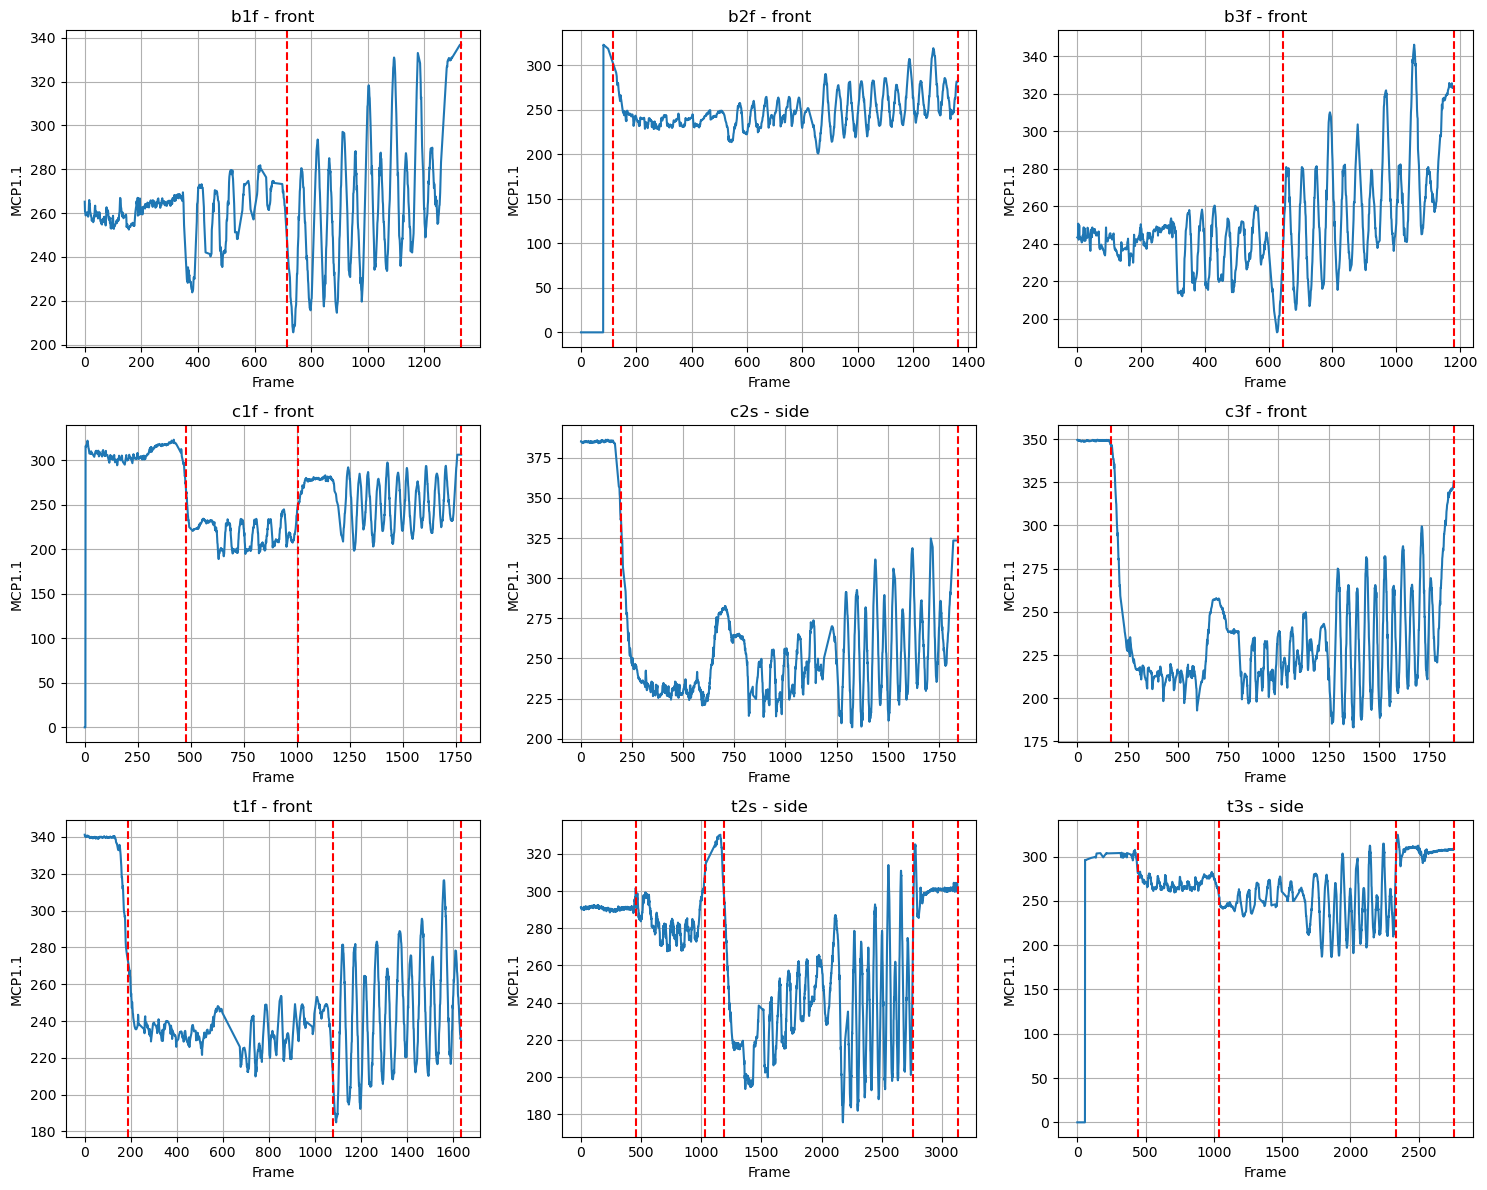

In [106]:
# Define number of plots per row
plots_per_row = 3
num_plots = len(success_list)
num_rows = int(np.ceil(num_plots / plots_per_row))

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()  # Make it 1D so it's easier to index

for i, name in enumerate(success_list):
    base_name = name[:-1]
    view = 'front' if name.endswith('f') else 'side'

    # Get signal
    df = dataframes[name]
    signal = df['MCP1.1'].to_numpy()
    time = np.arange(len(signal))

    # Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    change_points = row.iloc[0][view] if not row.empty else []

    # Plot in subplot
    ax = axes[i]
    ax.plot(time, signal, label='MCP1.1')
    for cp in change_points:
        ax.axvline(cp, color='red', linestyle='--')

    ax.set_title(f"{name} - {view}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("MCP1.1")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [139]:
# Create empty DataFrame to hold results
columns = ['dataset', 'movement', 'data', 'time', 'indices']
df_movements = pd.DataFrame(columns=columns)

for name in success_list:
    base_name = name[:-1]               # 'b1' from 'b1f'
    view = 'front' if name.endswith('f') else 'side'
    
    # 1. Get signal and time
    df = dataframes[name]
    x = df['MCP1.1'].to_numpy()
    t = df.index.to_numpy() if 'time' not in df else df['time'].to_numpy()

    # 2. Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    if row.empty:
        continue  # skip if no match

    change_points = row.iloc[0][view]
    if len(change_points) < 3:
        continue  # not enough points to split into 3 parts

    # 3. Define movement segments
    segment_info = {
        'hand_OC': (change_points[0], change_points[1]),
        'hand_PS': (change_points[1], change_points[2]),
        'arm_EF': (change_points[2], len(x))  # to end
    }

    for movement, (start, end) in segment_info.items():
        if end - start < 400:
            continue  # skip short segments

        segment_data = x[start:end]
        segment_time = t[start:end]

        df_movements = pd.concat([
            df_movements,
            pd.DataFrame([{
                'dataset': base_name,
                'movement': movement,
                'data': segment_data,
                'time': segment_time,
                'indices': (start, end)
            }])
        ], ignore_index=True)

# preview result
df_movements.head()
df_movements.tail()


,dataset,movement,data,time,indices
16,c3,hand_PS,"[309.50228428571427, 308.48220842105263, 307.4...","[1416, 1417, 1418, 1419, 1420, 1421, 1422, 142...","(1415, 2325)"
17,c3,arm_EF,"[336.15594, 341.42813, 343.06091, 345.35739, 3...","[2326, 2327, 2328, 2329, 2330, 2331, 2332, 233...","(2325, 3368)"
18,t3,hand_OC,"[398.48032, 393.82822, 391.99323, 391.08386, 3...","[296, 297, 298, 299, 300, 301, 302, 303, 304, ...","(295, 1320)"
19,t3,hand_PS,"[278.54636, 275.8075, 273.53549, 270.30017, 26...","[1321, 1322, 1323, 1324, 1325, 1326, 1327, 132...","(1320, 2140)"
20,t3,arm_EF,"[301.40118, 305.00659, 308.67151, 311.48022, 3...","[2141, 2142, 2143, 2144, 2145, 2146, 2147, 214...","(2140, 3531)"


In [161]:
# Apply and create new columns
df_movements[['peaks', 'troughs', 'euclidean_dis']] = df_movements.apply(compute_peaks_troughs, axis=1)
df_movements

Error processing row 13: 'NoneType' object is not subscriptable
Error processing row 14: 'NoneType' object is not subscriptable


,dataset,movement,data,time,indices,peaks,troughs,euclidean_dis
0,b1,hand_OC,"[0.0, 448.0502, 445.30121, 443.25018, 442.3430...","[1746, 1747, 1748, 1749, 1750, 1751, 1752, 175...","(1745, 2515)","[1973, 2085, 2142, 2195, 2281, 2370, 2469]","[2037, 2118, 2256, 2323, 2430]",1747 0.00000 1748 0.00000 1749 ...
1,b1,hand_PS,"[317.83844, 312.74094, 311.93942, 311.05396, 3...","[2516, 2517, 2518, 2519, 2520, 2521, 2522, 252...","(2515, 3215)","[2639, 2769, 2869, 2966, 3063, 3154]","[2573, 2702, 2811, 2918, 3011, 3105, 3184]",NA
2,b1,arm_EF,"[343.40897, 345.45416, 349.21518, 351.87399, 3...","[3216, 3217, 3218, 3219, 3220, 3221, 3222, 322...","(3215, 4258)","[3303, 3441, 3565, 3679, 3791, 3904]","[3373, 3499, 3637, 3748, 3861, 3973, 4082]",NA
3,b2,hand_OC,"[439.14294, 439.14536, 432.31442, 423.14078, 4...","[401, 402, 403, 404, 405, 406, 407, 408, 409, ...","(400, 1345)","[512, 666, 765, 835, 894, 982, 1057, 1293]","[429, 588, 707, 796, 862, 947, 1023, 1102]",402 335.53302 403 326.98547 404 31...
4,b2,hand_PS,"[311.82791, 312.01193, 310.13269, 306.78973, 3...","[1346, 1347, 1348, 1349, 1350, 1351, 1352, 135...","(1345, 2155)","[1453, 1622, 1726, 1813, 1916, 2011]","[1391, 1553, 1668, 1767, 1867, 1959, 2049]",NA
5,b2,arm_EF,"[335.06079, 339.45883, 342.71967, 346.3273, 34...","[2156, 2157, 2158, 2159, 2160, 2161, 2162, 216...","(2155, 3271)","[2247, 2384, 2506, 2629, 2742, 2853, 2915]","[2256, 2450, 2571, 2702, 2791, 2903]",NA
6,b3,hand_OC,"[452.02008, 448.15372, 445.60977, 438.82437, 4...","[336, 337, 338, 339, 340, 341, 342, 343, 344, ...","(335, 1330)","[433, 540, 687, 772, 880, 965, 1045, 1177, 1291]","[383, 510, 641, 712, 825, 904, 990, 1081, 1238...",337 376.68570 338 371.12354 339 36...
7,b3,hand_PS,"[325.61445755458516, 325.1283611790393, 324.64...","[1331, 1332, 1333, 1334, 1335, 1336, 1337, 133...","(1330, 2070)","[1485, 1543, 1657, 1765, 1870, 1961, 2040]","[1446, 1623, 1713, 1812, 1932, 2020]",NA
8,b3,arm_EF,"[350.39087590909094, 353.8283927272727, 357.26...","[2071, 2072, 2073, 2074, 2075, 2076, 2077, 207...","(2070, 3053)","[2164, 2297, 2356, 2411, 2472, 2524, 2577, 263...","[2251, 2342, 2484, 2564, 2683, 2788]",NA
9,c1,hand_OC,"[0.0, 0.0, 442.80359, 441.81766, 440.32602, 43...","[431, 432, 433, 434, 435, 436, 437, 438, 439, ...","(430, 1300)","[669, 730, 801, 890, 985, 1076, 1173, 1261]","[597, 709, 760, 840, 951, 1035, 1110, 1186]",432 440.57806 433 437.79498 434 43...


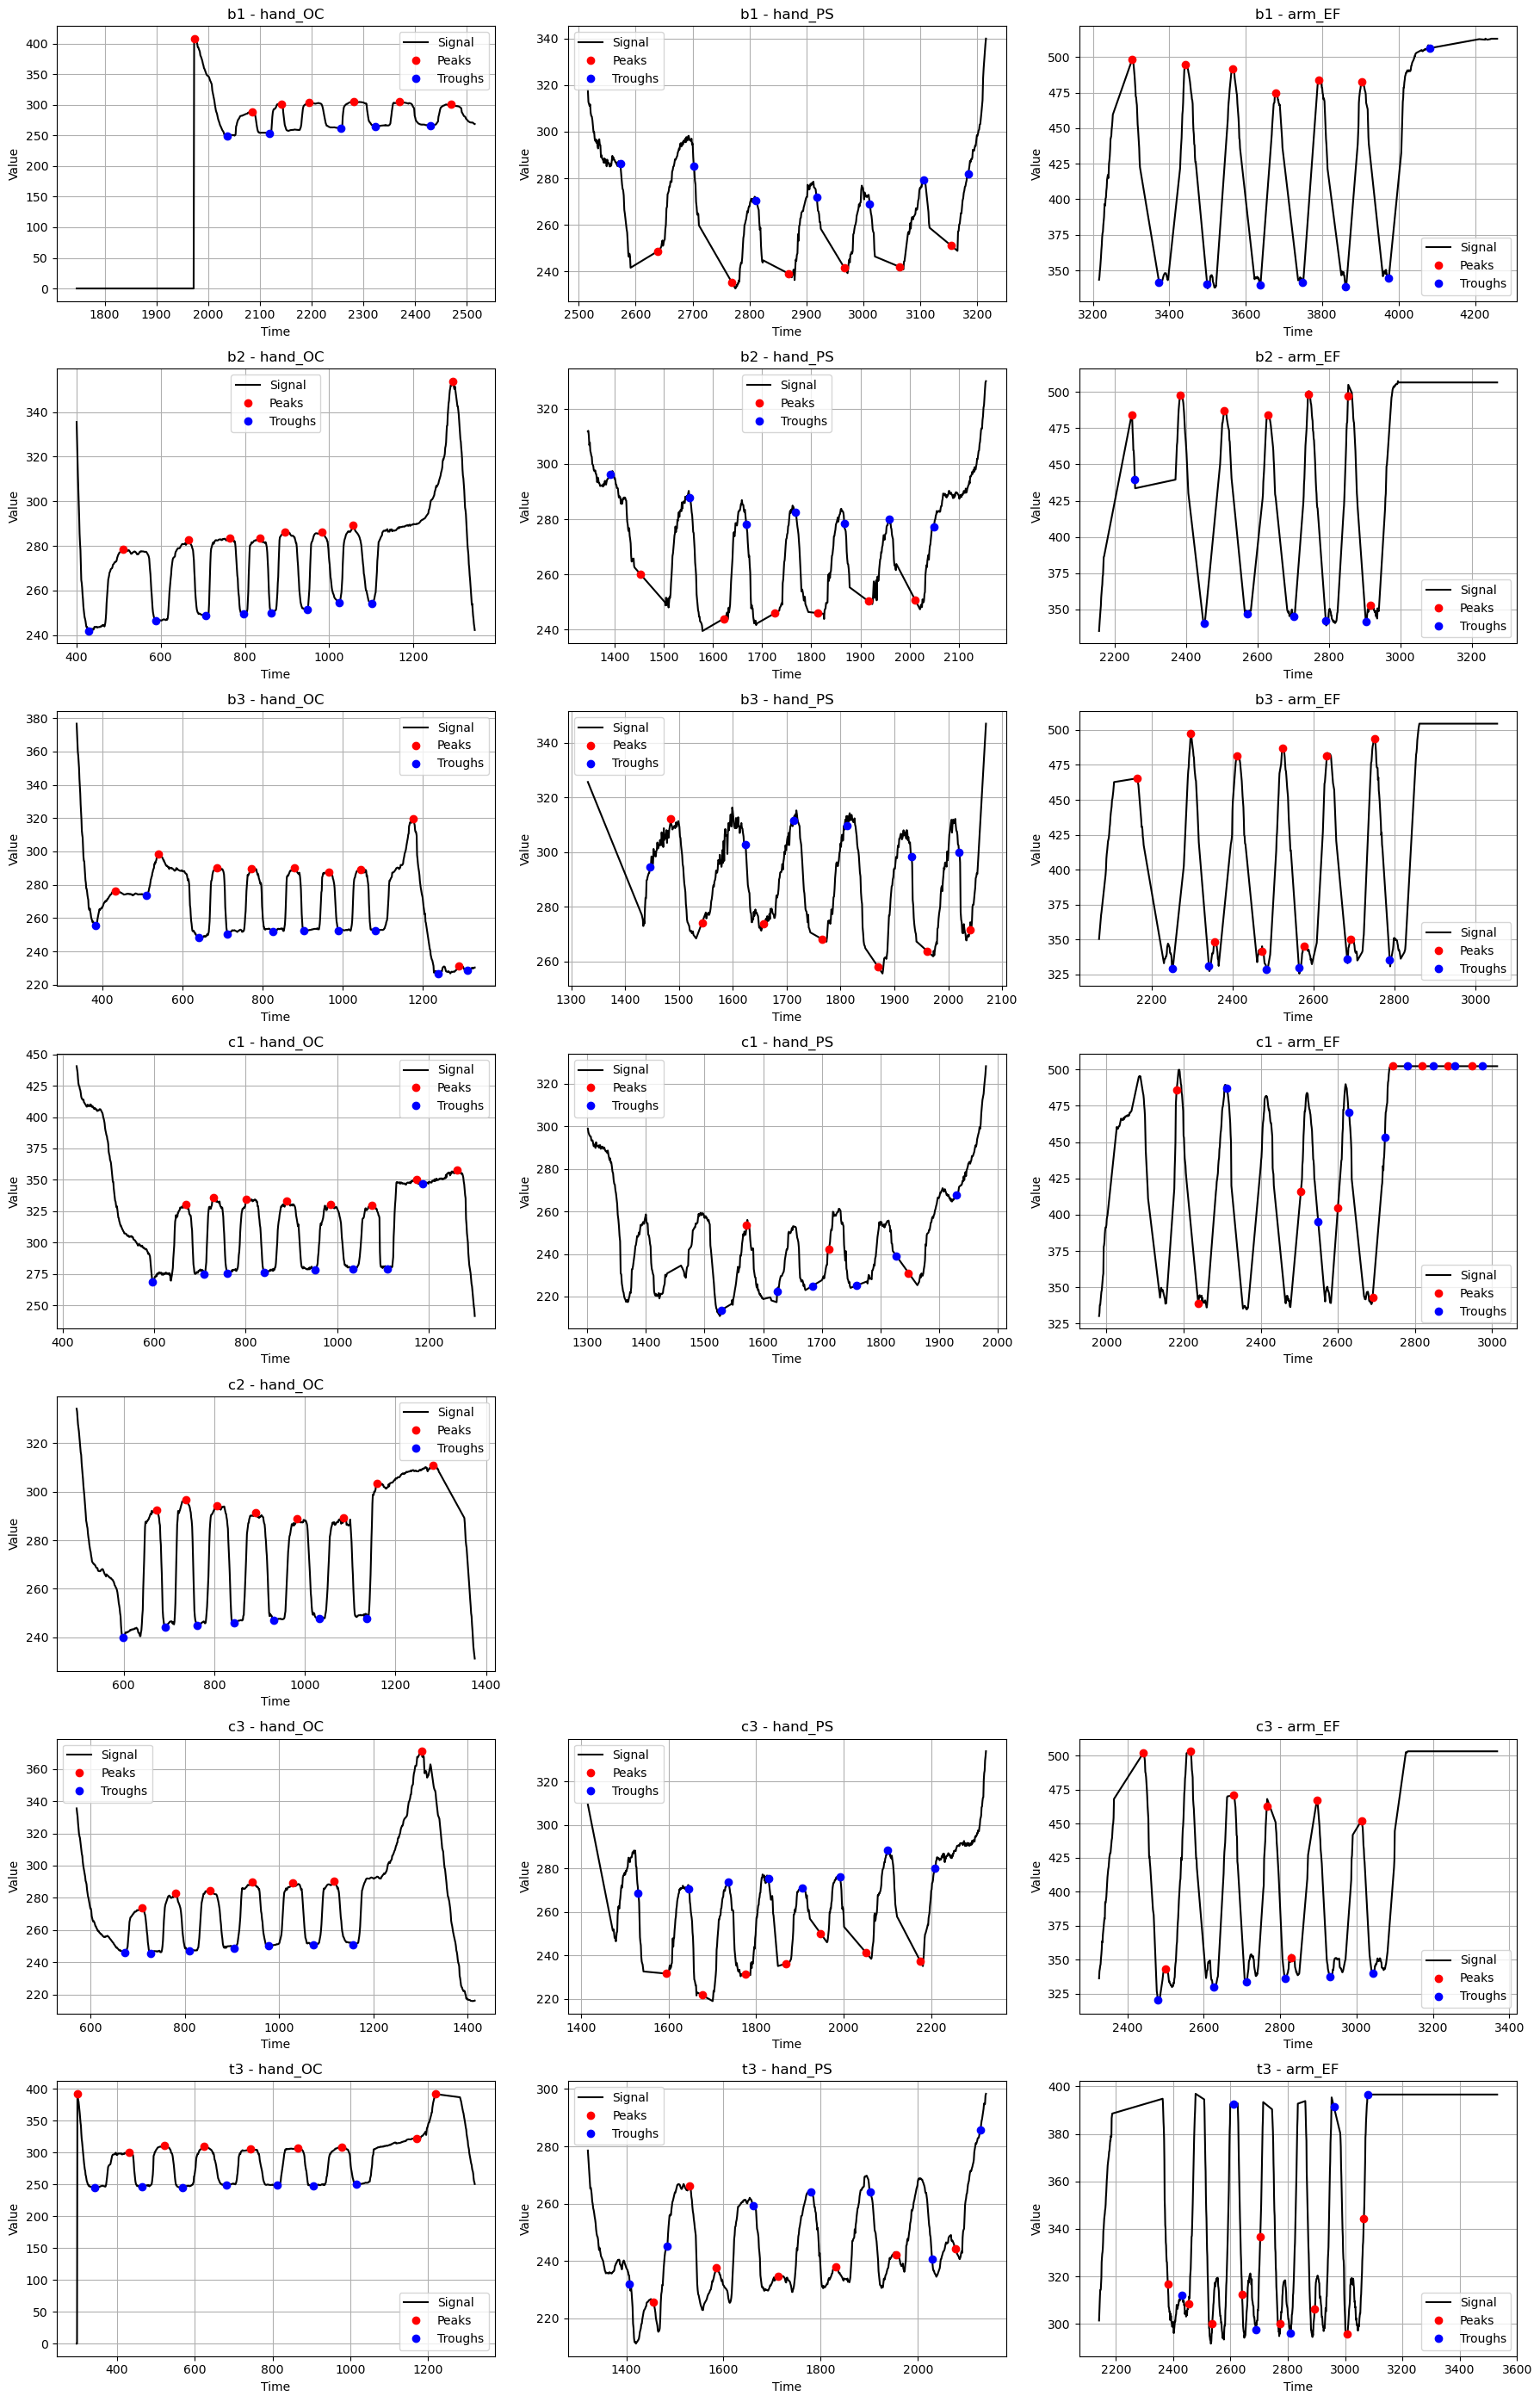

In [162]:
# Filter rows where 'peaks' is not None
# valid_rows = df_movements[df_movements['peaks'].notna()].reset_index()

num_plots = len(df_movements)
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()


for i, (idx, row) in enumerate(df_movements.iterrows()):
    ax = axes[i]

    if row['peaks'] is None:
        fig.delaxes(ax)
        continue


    if row['movement'] == 'hand_OC':
        data = row['euclidean_dis']
    else:
        data = row['data']
    
    # Plot time vs data
    ax.plot(row['time'], data, label='Signal', color='black')

    # Plot peaks (if any)
    if isinstance(row['peaks'], (np.ndarray, list)):
        ax.plot(row['peaks'], np.interp(row['peaks'], row['time'], data), 'ro', label='Peaks')

    # Plot troughs (if any)
    if isinstance(row['troughs'], (np.ndarray, list)):
        ax.plot(row['troughs'], np.interp(row['troughs'], row['time'], data), 'bo', label='Troughs')

    # Add titles and labels
    ax.set_title(f"{row['dataset']} - {row['movement']}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
